In [1]:
!pip install diffusers transformers accelerate safetensors flask-ngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 92.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.8 MB/s eta 0:00:00


In [2]:
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.7/718.7 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-7.0.0-py3-none-any.whl size=21129 sha256=257f32b2a33e818ff1707013f33708df8b60f6055ac5477c6a928cb58c09b57b
  Stored in directory: /root/.cache/pip/wheels/60/29/7b/f64332aa7e5e88fbd56d4002185ae22dcdc83b35b3d1c2cbf5
Successfully built pyngrok


In [3]:
# !kill 30402
# !kill 2056
!ps

    PID TTY          TIME CMD
      1 ?        00:00:00 docker-init
      7 ?        00:00:01 node
     18 ?        00:00:00 oom_monitor.sh
     20 ?        00:00:00 run.sh
     22 ?        00:00:00 kernel_manager_
     24 ?        00:00:00 tail
     61 ?        00:00:05 python3 <defunct>
     62 ?        00:00:00 colab-fileshim.
    107 ?        00:00:03 jupyter-noteboo
    108 ?        00:00:00 dap_multiplexer
    768 ?        00:00:01 python3
    843 ?        00:00:00 python3
    993 ?        00:00:00 language_servic
    998 ?        00:00:00 node
   1037 ?        00:00:00 sleep
   1038 ?        00:00:00 ps


In [4]:
import getpass

from pyngrok import ngrok, conf

print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
conf.get_default().auth_token = "2XP6QUvSrC2YiA6aoZN5Jb5v9eG_7XAi7EUHS8o8pFRWT4fwB"

# Open a TCP ngrok tunnel to the SSH server
connection_string = ngrok.connect("22", "tcp").public_url

ssh_url, port = connection_string.strip("tcp://").split(":")
print(f" * ngrok tunnel available, access with `ssh root@{ssh_url} -p{port}`")

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth


 * ngrok tunnel available, access with `ssh root@2.tcp.ngrok.io -p15298`


In [5]:
!pip install opencv-contrib-python

In [6]:
from diffusers import StableDiffusionImg2ImgPipeline
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel
import torch
from diffusers import DPMSolverMultistepScheduler
from PIL import Image
import cv2
import numpy as np
from transformers import AutoImageProcessor, UperNetForSemanticSegmentation

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-seg", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "stablediffusionapi/realistic-vision-v51", controlnet=controlnet, torch_dtype=torch.float16,enhance_prompt="yes"
)
pipe.to("cuda")
components = {k: v for k, v in pipe.components.items() if k != "controlnet"}
pipe = StableDiffusionImg2ImgPipeline(**components)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras=True, algorithm_type="sde-dpmsolver++")
final_pipe_line = StableDiffusionControlNetImg2ImgPipeline(**pipe.components, controlnet=controlnet)

controlnet2 = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)

final_pipe_line_canny = StableDiffusionControlNetImg2ImgPipeline(**pipe.components, controlnet=controlnet2)
final_pipe_line_canny.to("cuda")
image_processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-convnext-small")
image_segmentor = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-convnext-small")
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]
def process_image(image,prompt,negative_prompt):
    processed_image = pipe(prompt=prompt, negative_prompt=negative_prompt, image=image, strength=0.38, num_inference_steps=40, guidance_scale=8).images[0]
    return processed_image

def segment_filters(image):
    pixel_values = image_processor(image, return_tensors="pt").pixel_values
    with torch.no_grad():
      outputs = image_segmentor(pixel_values)

    seg = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3

    for label, color in enumerate(ade_palette()):
        color_seg[seg == label, :] = color

    color_seg = color_seg.astype(np.uint8)

    image = Image.fromarray(color_seg)
    return image

def process_filters(image):
    canny_image = np.array(image)
    low_threshold = 100
    high_threshold = 200

    canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)
    canny_image = canny_image[:, :, None]
    canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
    canny_image = Image.fromarray(canny_image)
    return canny_image

def process_image_final(image,control_image,prompt,negative_prompt):

    processed_image = final_pipe_line(prompt=prompt, negative_prompt=negative_prompt, image=image, control_image=control_image, strength=0.5).images[0]
    return processed_image

def process_image_final_canny(image,control_image,prompt,negative_prompt):

    processed_image = final_pipe_line_canny(prompt=prompt, negative_prompt=negative_prompt, image=image, control_image=control_image, strength=0.5).images[0]
    return processed_image

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

text_encoder/model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Keyword arguments {'enhance_prompt': 'yes'} are not expected by StableDiffusionControlNetImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [7]:
import os
import threading
import io
from flask import Flask,request,send_file
from pyngrok import ngrok
import sys
import datetime
import cv2
import shutil
datestamp = datetime.datetime.now().strftime('%Y-%m-%d')
app = Flask(__name__)
port = "5000"
from logging.config import dictConfig
os.makedirs("logs",exist_ok=True)
dictConfig(
    {
        "version": 1,
         "formatters":{
            "default": {
                "format": "[%(asctime)s] %(levelname)s | %(module)s >>> %(message)s",
                "datefmt": "%B %d, %Y %H:%M:%S %Z",
            }
        },
        "handlers": {
            "console": {
                "class": "logging.StreamHandler",
                "stream": "ext://sys.stdout",
                "formatter": "default",
            },
            "file": {
                "class": "logging.FileHandler",
                "filename": "./logs/application_log-"+datestamp+".log",
                "formatter": "default",
            },
        },
        "root": {"level": "DEBUG", "handlers": ["console", "file"]},
    }
)
# Open a ngrok tunnel to the HTTP server
public_url = ngrok.connect(port).public_url
print(" * ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}\"".format(public_url, port))

# Update any base URLs to use the public ngrok URL
# app.config["BASE_URL"] = public_url

# ... Update inbound traffic via APIs to use the public-facing ngrok URL


# Define Flask routes
@app.route("/")
def index():
    return "Hello from Colab!"

@app.route("/create_folder",methods=['POST'])
def create_folder():
    video_name=request.form.get("video_name","")
    path=video_name
    os.makedirs(path,exist_ok=True)
    return {"code":"200","folder_name":path}

@app.route("/download_dataset",methods=['POST'])
def download_dataset():
    folder_name=request.form.get("folder_name","")
    shutil.make_archive(folder_name, 'zip', folder_name)
    return send_file(folder_name+".zip", as_attachment=True)

@app.route("/process_image_individual",methods=['POST'])
def process_image_individual():
    image = request.files['image']
    prompt = request.form.get("prompt","")
    negative_prompt = request.form.get("negative_prompt","")
    count=request.form.get("count","")
    folder_name=request.form.get("folder_name","")
    path=folder_name
    img = Image.open(image.stream)
    img.save(os.path.join(path,"image_%s_input.jpg" % count))
    one_step=process_image(img,prompt,negative_prompt)
    control=segment_filters(img)
    control.save(os.path.join(path,"image_%s_segment.jpg" % count))
    final_image=process_image_final(one_step,control,prompt,negative_prompt)
    canny=process_filters(final_image)
    canny.save(os.path.join(path,"image_%s_canny.jpg" % count))
    final_canny=process_image_final_canny(final_image,canny,prompt,negative_prompt)
    final_canny.save(os.path.join(path,"image_%s_processed.jpg" % (count)))
    return {"code":"200"}

@app.route("/image_process",methods=['POST'])
def images_process():
    video = request.files['video']
    ts = int(datetime.datetime.now().timestamp())
    video_name=video.filename.split(".")[0]
    path=video_name+"_"+str(ts)
    count = 0
    os.makedirs(path,exist_ok=True)
    vid_path=os.path.join(path,video.filename)
    video.save(vid_path)
    vidcap = cv2.VideoCapture(vid_path)
    success,image = vidcap.read()
    prompt = request.form.get("prompt","")
    negative_prompt = request.form.get("negative_prompt","")
    length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    mod=int(length/10)
    image_counter=1
    while success:
        print(count+1," Is ",success,file=sys.stderr)
        if count%mod==0:
            cv2.imwrite(os.path.join(path,"image_%d_input.jpg" % image_counter), image)     # save frame as JPEG file
            print(count,file=sys.stderr)
            img = Image.open(os.path.join(path,"image_%d_input.jpg" % image_counter))
            one_step=process_image(img,prompt,negative_prompt)
            control=segment_filters(img)
            control.save(os.path.join(path,"image_%d_segment.jpg" % image_counter))
            final_image=process_image_final(one_step,control,prompt,negative_prompt)
            final_image.save(os.path.join(path,"image_%d_processed.jpg" % image_counter))
            image_counter+=1
        count += 1
        success,image = vidcap.read()
    shutil.make_archive(video_name, 'zip', path)
    return send_file(video_name+".zip", as_attachment=True)
    # img_io = io.BytesIO()
    # final_image.save(img_io, 'JPEG', quality=70)
    # img_io.seek(0)
    # return send_file(img_io, mimetype='image/jpeg')
# Start the Flask server in a new thread
if __name__ == '__main__':
    app.run()

 * ngrok tunnel "https://955f-34-143-227-86.ngrok-free.app" -> "http://127.0.0.1:5000"
 * Serving Flask app '__main__'
 * Debug mode: off
[October 29, 2023 08:08:25 UTC] INFO | _internal >>> WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
[October 29, 2023 08:08:25 UTC] INFO | _internal >>> Press CTRL+C to quit
[October 29, 2023 08:21:11 UTC] INFO | _internal >>> 127.0.0.1 - - [29/Oct/2023 08:21:11] "POST /create_folder HTTP/1.1" 200 -


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[October 29, 2023 08:22:59 UTC] INFO | _internal >>> 127.0.0.1 - - [29/Oct/2023 08:22:59] "POST /process_image_individual HTTP/1.1" 200 -


In [ ]:
input_image=Image.open(open("image_1_input.jpg","rb"))
step1_image=process_image(input_image,"vibrant road, traffic, environment, best quality, ultra high res, photorealistic, realistic weather, rain, realistic vehicles, accurate backgrounds, high definition backgrounds, Clear roads","paintings, sketches, worst quality, low quality, normal quality, lowres, normal quality, monochrome, grayscale,unnecssar shadows, added details,white lines, white streaks, main vehicle in the image")

  0%|          | 0/15 [00:00<?, ?it/s]

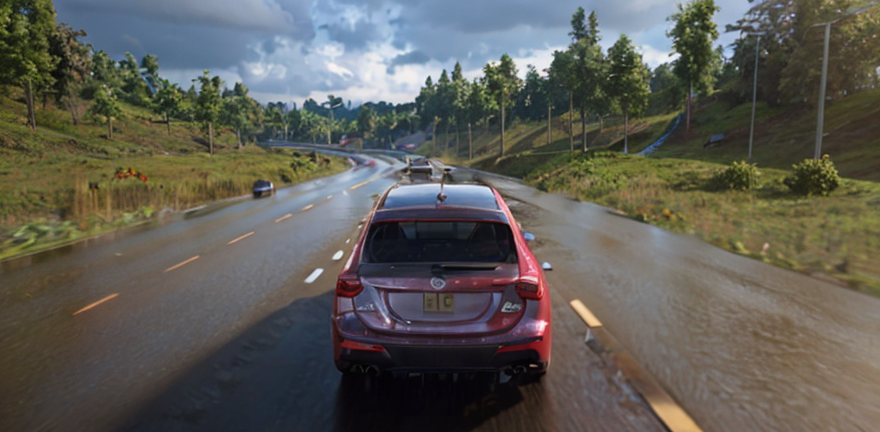

In [ ]:
step1_image

In [ ]:
step2_image=segment_filters(step1_image)

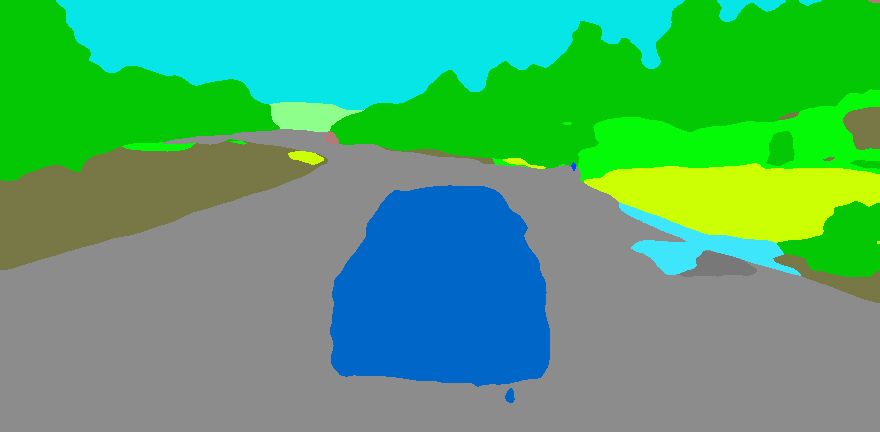

In [ ]:
step2_image

In [ ]:
step_3=process_image_final(step1_image,step2_image,"vibrant road, traffic, environment, best quality, ultra high res, photorealistic, realistic weather, rain, realistic vehicles, accurate backgrounds, high definition backgrounds, Clear roads","paintings, sketches, worst quality, low quality, normal quality, lowres, normal quality, monochrome, grayscale,unnecssar shadows, added details,white lines, white streaks, main vehicle in the image")

  0%|          | 0/25 [00:00<?, ?it/s]

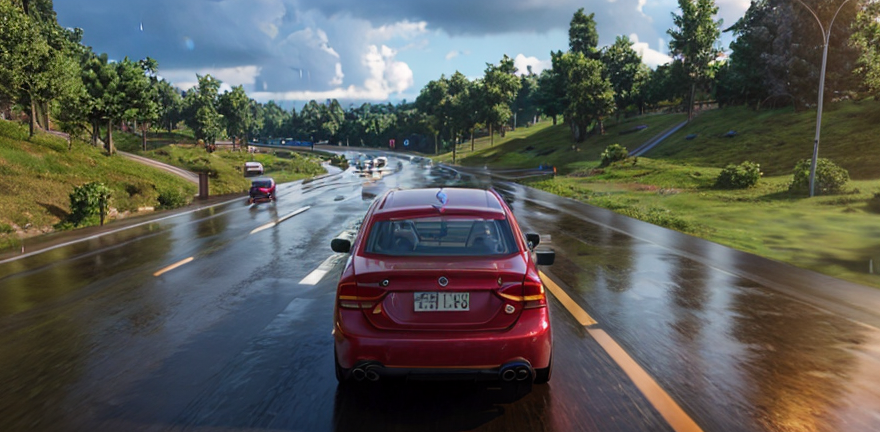

In [ ]:
step_3

In [ ]:
step_4=process_filters(step_3)

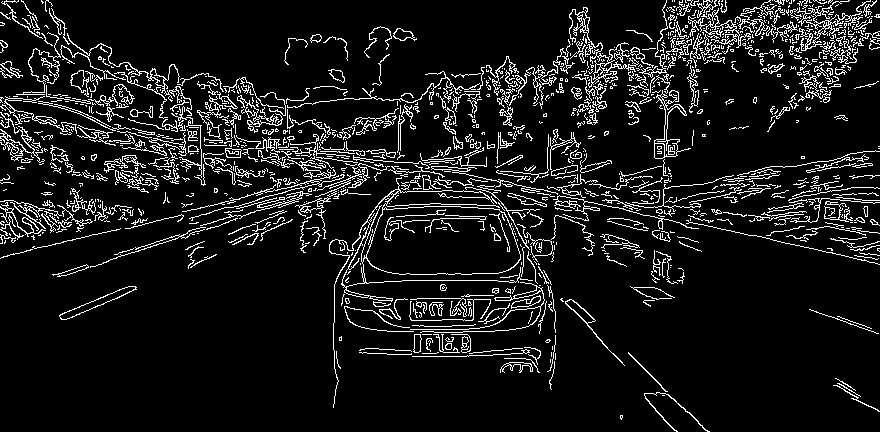

In [ ]:
step_4

In [ ]:
final_image=process_image_final_canny(step_3,step_4,"vibrant road, traffic, environment, best quality, ultra high res, photorealistic, realistic weather, rain, realistic vehicles, accurate backgrounds, high definition backgrounds, Clear roads","paintings, sketches, worst quality, low quality, normal quality, lowres, normal quality, monochrome, grayscale,unnecssar shadows, added details,white lines, white streaks, smaller vehicles, background vehicles, main vehicle in the image")

  0%|          | 0/25 [00:00<?, ?it/s]

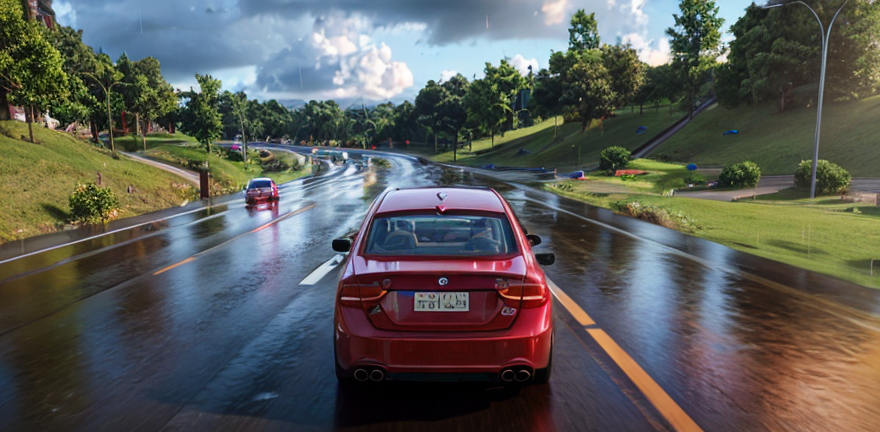

In [ ]:
final_image

In [10]:
shutil.make_archive("Images_Generation_1698567669", 'zip', "/content/Images_Generation_1698567669")
# shutil.make_archive("Images_Generation_1698548909", 'zip', "/content/Images_Generation_1698548909")
# shutil.make_archive("Images_Generation_1698548967", 'zip', "/content/Images_Generation_1698548967")
# shutil.make_archive("Images_Generation_1698549094", 'zip', "/content/Images_Generation_1698549094")

'/content/Images_Generation_1698567669.zip'

In [ ]:
# !kill 2379
# !kill 16074
# !kill 240
!rm -r "Images_Generation_D:"
!ps

    PID TTY          TIME CMD
      1 ?        00:00:00 docker-init
      6 ?        00:00:12 node
     16 ?        00:00:03 oom_monitor.sh
     18 ?        00:00:00 run.sh
     20 ?        00:00:13 kernel_manager_
     36 ?        00:00:00 tail
     53 ?        00:00:05 python3 <defunct>
     54 ?        00:00:01 colab-fileshim.
     99 ?        00:00:23 jupyter-noteboo
    101 ?        00:00:10 dap_multiplexer
   1214 ?        00:13:42 python3
   1275 ?        00:00:19 python3
   2036 ?        00:00:00 language_servic
   2042 ?        00:01:01 node
  32385 ?        00:00:00 sleep
  32389 ?        00:00:00 ps
